In [1]:
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.wcs import utils
from astropy import stats
from photutils import CircularAnnulus, CircularAperture
from photutils.aperture import aperture_photometry as aper_phot
import numpy as np
import astropy.io.fits as pyfits
from astropy.time import Time
#import matplotlib.colors as colors

# Funtion definitions

In [126]:
def import_fits(fits_image):
    hdul = fits.open(fits_image)
    hdr=hdul[0].header
    data = hdul[0].data
    hdul.close()
    return [hdr,data] 

In [3]:
def show_image(data, color_bar_label='Intensity (Jy/beam)', circle=None, zoom=None):
    if circle or zoom is not None:
        fig = plt.gcf()
        ax = fig.gca()
    if circle is not None:
        x_orig=circle[0]
        y_orig=circle[1]
        r=circle[2]
        orig_pix = (x_orig,y_orig)
        plt.plot(x_orig,y_orig, 'ro')
        circle1 = plt.Circle(orig_pix, r, color='r',fill=False)
        ax.add_artist(circle1)
    if zoom is not None:
        x_min=zoom[0]
        x_max=zoom[1]
        y_min=zoom[2]
        y_max=zoom[3]
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
    plt.imshow(data)        
    cbar=plt.colorbar()
    cbar.set_label(color_bar_label, rotation=90)        
    plt.show()

In [155]:
def make_average_data(data,start_circle,width=1,remove_center=False):
    x_orig=start_circle[0]
    y_orig=start_circle[1]
    r=start_circle[2]
    orig_pix = (x_orig,y_orig)    
    lim_sup = min(np.array(data.shape)-[y_orig,x_orig]-1) #minimum distance from the central point to the image right and lower edges 
    lim_inf = min(np.array([y_orig,x_orig])) #minimum distance from the central point to the image left and superior edges 
    lim = min(lim_sup,lim_inf) #minimum distance to the image edges
    aper = [CircularAnnulus(orig_pix, i, i+width) for i in np.arange(r,int(lim),width)]
    phot = aper_phot(data,aper)
    flux_aper = [phot['aperture_sum_'+str(i)][0] for i in np.arange(len(aper))]
    area_aper =  [i.area for i in aper]
    aver_aper = np.array(flux_aper)/np.array(area_aper)
    #make a fits with the average values
    #create new array with shape of data
    zero_data=np.zeros(data.shape)
    #making the central pixels the original ones  
    aveg_data=zero_data.copy()
    if remove_center:
        central_aperture = CircularAperture(orig_pix, r)
        mask_central = central_aperture.to_mask(method='center') 
        im_central=mask_central.multiply(data)
        aveg_data[y_orig-r:y_orig+r+1,x_orig-r:x_orig+r+1]=im_central
    #make masks from apertures
    mask_aper = [i.to_mask(method='center') for i in aper] 
    #create masks from the apertures filled with the averaged values 
    im=[i.multiply(data) for i in mask_aper]
    for i, avg in enumerate(aver_aper):
        mask = im[i] != 0
        im[i][mask] = avg
    for mask in im:
        semi_axis=int((mask.shape[0]-1)/2)
        aveg_data[y_orig-semi_axis:y_orig+semi_axis+1,x_orig-semi_axis:x_orig+semi_axis+1]=aveg_data[y_orig-semi_axis:y_orig+semi_axis+1,x_orig-semi_axis:x_orig+semi_axis+1]+mask      
    return aveg_data

In [162]:
def write_fits(data, header, outname):
    hdu = fits.PrimaryHDU(data=data, header=header)
    nt = Time.now()
    hdu.header.set('DATE',str(nt))
    hdu.header.set('HISTORY','')
    hdu.writeto(outname+'.fits')

# Lets do the image!

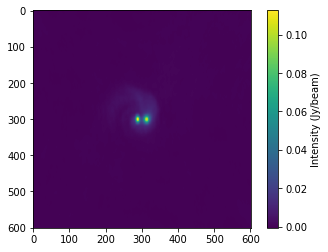

In [177]:
fits_image_name='SVS13.cont.p6s-3.pbcor-zoom-big-dropped.fits'
output_fits_name='SVS13-spirals'
hdr_data=import_fits(fits_image_name)
hdr=hdr_data[0]
data=hdr_data[1]
show_image(data)

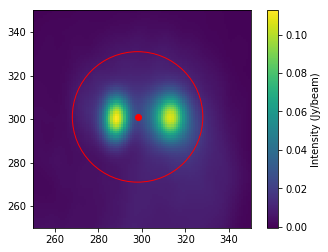

In [181]:
x_orig=298 #x coordinate of the central (red) point
y_orig=301 #y coordinate of the central (red) point
r = 30 # radius of the (red) circle in pixels 
circle=[x_orig,y_orig,r]
x_min=250
x_max=350
y_min=x_min
y_max=x_max
zoom=[x_min,x_max,y_min,y_max]
show_image(data,circle=circle,zoom=zoom)

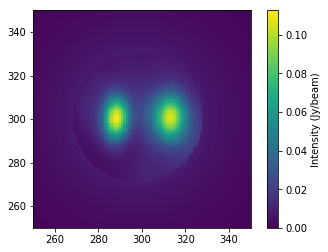

In [182]:
aver_data = make_average_data(data,start_circle=circle,remove_center=True)
show_image(aver_data,zoom=zoom)

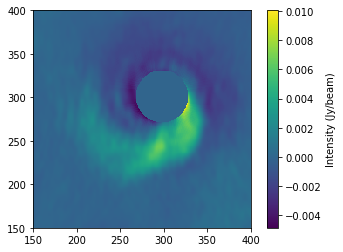

In [184]:
new_data=data-aver_data
show_image(new_data,zoom=[150,400,150,400])

In [185]:
write_fits(new_data,hdr,output_fits_name)
write_fits(aver_data,hdr,output_fits_name+'_average')